# Yosemite Village yearly weather

## Part 0 - Data Preprocessing 
Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
import sklearn.linear_model 
from sklearn.metrics import classification_report

In [3]:
#Load Files

years = range(2011, 2017) 
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8] #[UTC_time, UTC date, Temperature]
tr = [np.loadtxt(f, usecols=usecols) for f in files]
ts = np.loadtxt('CRNS0101-05-2016-CA_Yosemite_Village_12_W.txt', usecols=usecols)

In [4]:
## TEST SET ## 

#convert dates from YYYYMMDD format to days since start of year
ts_year = '20160101'
ts_year_start = datetime.strptime(ts_year, '%Y%m%d') #get year start from string
ts_date=pd.to_datetime(ts[:,0], format='%Y%m%d') #convert all floats to datetime 
ts_date.to_numpy()
ts_days = ts_date - ts_year_start #compute days since start of year
ts_days = ts_days / np.timedelta64(1, 'D') #convert time deltas to integers
ts_days=ts_days.to_numpy() #convert back to numpy from pandas dataframe

#convert time of day from HHMM to minutes since start of day 
hour_mins = np.divmod(ts[:,1],np.full((105408,), 100)) #creates two rows for hour and minutes each
ts_minutes = (hour_mins[0]*60)+hour_mins[1] #add them together to get new array of time 
ts_minutes = ts_minutes.astype(int) #convert timestamps to integers

#merge all columns
test = np.column_stack((ts_minutes, ts_days,ts[:,2]))

 #an array of minutes, days, and temp columns
np.random.shuffle(test)
print('test set shape ==', test.shape)
test


test set shape == (105408, 3)


array([[9.80e+02, 1.34e+02, 1.17e+01],
       [1.05e+03, 3.13e+02, 1.62e+01],
       [6.70e+02, 3.27e+02, 3.00e-01],
       ...,
       [8.15e+02, 6.10e+01, 7.20e+00],
       [4.75e+02, 9.70e+01, 1.36e+01],
       [8.70e+02, 5.40e+01, 8.10e+00]])

In [5]:

## TRAIN SET ## 

tr_years = ['20110101','20120101','20130101','20140101','20150101']
train_dates = [] #list for arrays of days for each year 
train_minutes = [] #list for array of day minutes for each year

#convert date 
for i in range(len(tr_years)):

    tr_year_start = datetime.strptime(tr_years[i], '%Y%m%d') #get year start
    year_data = tr[i] #get data for that year
    year_data=pd.to_datetime(year_data[:,0], format='%Y%m%d') #convert to datetime objects 
    year_data.to_numpy() 
    year_data = year_data - tr_year_start #compute days since start of year
    year_data = year_data / np.timedelta64(1, 'D') #convert timedeltas to integers
    year_data=year_data.to_numpy() #convert dataframe to array
    train_dates.append(year_data) #add to train set 
    
   
#convert minutes
for i in range(len(tr_years)):
    
    #if statements because some years have different number of data
    if tr[i][:,1].shape == (105120,):
        #creates to arrays of hours and minutes each
        h_n_m = np.divmod(tr[i][:,1],np.full((105120,), 100)) 
        #add hour and minute arrays to get minutes since day start
        train_minutes.append((h_n_m[0]*60)+h_n_m[1]) #add to train_set
        h_n_m =0 #reset for next iter
        
    else: 
        h_n_m = np.divmod(tr[i][:,1],np.full((105408,), 100))
        train_minutes.append((h_n_m[0]*60)+h_n_m[1])
        h_n_m =0
        
#merge everything
train_set = []
for i in range(len(tr_years)):
    train_set.append(np.column_stack((train_minutes[i], train_dates[i],tr[i][:,2])))
    
train_set #this is a list of 5 np arrays of minutes, dates, and temp columns each
#turn this into a big numpy array 
train = np.vstack((train_set[0],train_set[1],train_set[2],train_set[3],train_set[4]))
np.random.shuffle(train)
print('training set shape ==', train.shape)
train

training set shape == (525888, 3)


array([[ 9.100e+02,  1.890e+02,  1.800e+01],
       [ 8.000e+01,  1.220e+02,  1.600e+01],
       [ 1.120e+03,  2.200e+01, -1.200e+00],
       ...,
       [ 1.205e+03,  2.960e+02,  1.910e+01],
       [ 1.295e+03,  3.270e+02,  3.300e+00],
       [ 6.600e+02,  3.600e+01,  7.900e+00]])

### Part 1 - Applying Radial Basis Functions 
Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.

In [ ]:
#remove outlier temperature values 
train = np.delete(train, np.where((train[:,2] <= -8000))[0], axis=0)
test = np.delete(test, np.where((test[:,2] <= -8000))[0], axis=0)

n = 50000
x_train = train[:n,[0,1]]#.reshape(-1,1)
y_train = train[:n,[2]]#.reshape(-1, 1)
x_test = test[:n,[0,1]]
y_test = test[:n,2]
print(y_test.min(),y_test.max())
print(x_train.shape, y_train.shape)

np.random.seed(123)

d = 2
m = 100
reg_coef = 0.1
b = 2
n_centroids = 100

def compute_sigmasq(X): 
    xcross = np.dot(X, X.T)
    xnorms = np.repeat(np.diag(np.dot(X, X.T)).reshape(1, -1), np.size(X, axis=0), axis=0)
    return(np.median(xnorms - 2*xcross + xnorms.T))


def get_centroids(X, n_centroids):
    # Find the indeces
    idx = np.random.randint(np.size(X, axis=0), size=n_centroids)
    # Use indeces to grab rows
    return(X[idx, :])

def cal_distance(x,cent_i):
    ## calculate the distance between the centroid and the other elements
    return(np.sum((x - cent_i)**2))

# Find sigmasquared for the rbf
sigmasq = compute_sigmasq(x_train)
centroids = get_centroids(x_train, n_centroids)
print(sigmasq)

X= x_train


## After this line my implementations ####
phi_train = np.ones((n,1))
for i in range(n_centroids):
    cent_i  = centroids[i,:] # get the ith centroid
    dist_i = np.apply_along_axis(cal_distance , 1, X,cent_i) ## distance matrix for i th centroid
    phi_i = np.exp(-dist_i/sigmasq) ## 
    phi_i = np.reshape(phi_i,(n,1)) # dummy rehsape to (n,1)  
    phi_train = np.hstack((phi_train,phi_i)) # horizontally stack the matrix

inv_phi = np.linalg.pinv(phi_train) # get the psudoinverse for regular linear regression

#linear regression coefficiet
coefs = np.matmul(inv_phi,y_train) ## compute the weights
coefs = np.reshape(coefs,(n_centroids+1,1))  ## dummy reshape


## create phi test
phi_test = np.ones((n,1))
for i in range(n_centroids):
    cent_i  = centroids[i,:] # get the ith centroid
    dist_i = np.apply_along_axis(cal_distance , 1, x_test,cent_i) ## distance matrix for i th centroid
    phi_i = np.exp(-dist_i/sigmasq)
    phi_i = np.reshape(phi_i,(n,1)) # dummy rehsape 
    phi_test = np.hstack((phi_test,phi_i))

y_predict = np.matmul(phi_test,coefs)

plt.plot(y_test,y_predict,'*')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('n_centroid = ' +  str(n_centroids))

In [72]:
sigma = sig = 0.1
alp = 0.0001
rbf = rbf_kernel(y_train, x_train, gamma=1.0/sigma)
regression = linear_model.Lasso(alpha=alp, fit_intercept=False)
regression.fit(rbf, y_train)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [73]:
print('R2 square ==',regression.score(rbf,y_train))
#print(r2_score(rbf,y_train))
#print('Classification Report', classification_report(rbf,y_train))
all_rbf = np.linspace(-11, 28.0, 10000).reshape(-1, 1)
print(y_train.min(), y_train.max())
print(all_rbf.shape == y_train.shape)

expanded_rbf = rbf_kernel(all_rbf, y_train, gamma=1 / sig)
#all_y = regression.predict(expanded_rbf)

#x_train

R2 square == 0.4026662810987932
-11.4 28.2
False


In [68]:
expanded_rbf.shape
#plt.figure()
#plt.plot(all_rbf, all_y)
print(x_train.shape)
print(y_train.shape)
print(expanded_rbf.shape)
print(all_rbf.shape)

(10000, 1)
(5000, 1)
(10000, 5000)
(10000, 1)


In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

np.random.seed(123)

n = 1000
d = 2
m = 100
reg_coef = 0.1
b = 2
n_centroids = 100


# Explanatory variables are uniformly distributed
#X = np.random.uniform(-4, 4, size=(n, d))
X = train[:,[0,1]]

# Response is a multivariate normal 
target_normal = multivariate_normal(mean=np.random.normal(size=d), cov=np.eye(d))
y = target_normal.pdf(X)

Xhat = np.random.uniform(-4, 4, size=(n, d))
yactual = target_normal.pdf(Xhat)

def compute_sigmasq(X): 
    xcross = np.dot(X, X.T)
    xnorms = np.repeat(np.diag(np.dot(X, X.T)).reshape(1, -1), np.size(X, axis=0), axis=0)
    return(np.median(xnorms - 2*xcross + xnorms.T))
# Find sigmasquared for the rbf
sigmasq = compute_sigmasq(X)

def get_centroids(X, n_centroids):
    # Find the indeces
    idx = np.random.randint(np.size(X, axis=0), size=n_centroids)
    # Use indeces to grab rows
    return(X[idx, :])

centroids = get_centroids(X, n_centroids)


## After this line my implementations #####

def cal_distance(x,cent_i):
    ## calculate the distance between the centroid and the other elements
    return(np.sum((x - cent_i)**2))


phi_train = np.ones((n,1))
for i in range(n_centroids):
    cent_i  = centroids[i,:] # get the ith centroid
    dist_i = np.apply_along_axis(cal_distance , 1, X,cent_i) ## distance matrix for i th centroid
    phi_i = np.exp(-dist_i/sigmasq) ## 
    phi_i = np.reshape(phi_i,(n,1)) # dummy rehsape to (n,1)  
    phi_train = np.hstack((phi_train,phi_i)) # horizontally stack the matrix

inv_phi = np.linalg.pinv(phi_train) # get the psudoinverse for regular linear regression

#linear regression coefficiet
coefs = np.matmul(inv_phi,y) ## compute the weights
coefs = np.reshape(coefs,(n_centroids+1,1))  ## dummy reshape

## create phi test
phi_test = np.ones((n,1))
for i in range(n_centroids):
    cent_i  = centroids[i,:] # get the ith centroid
    dist_i = np.apply_along_axis(cal_distance , 1, Xhat,cent_i) ## distance matrix for i th centroid
    phi_i = np.exp(-dist_i/sigmasq)
    phi_i = np.reshape(phi_i,(n,1)) # dummy rehsape 
    phi_test = np.hstack((phi_test,phi_i))


y_predict = np.matmul(phi_test,coefs)

plt.plot(yactual,y_predict,'*')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('n_centroid = ' +  str(n_centroids))

NameError: ignored

### Part 2 - Build Linear Parameter Model 
Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

## Part 3 - Visualization
- Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.
- (Optional) Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!

## Part 4 - Evaluation 
Using R², quantify how your model performs on the testing data if you:
- Train with just the daily component of the model
- Train with just the yearly component of the model
- Train with the full model.

[[ 2.0110101e+07  5.0000000e+00 -6.4000000e+00]
 [ 2.0110101e+07  1.0000000e+01 -6.5000000e+00]
 [ 2.0110101e+07  1.5000000e+01 -6.5000000e+00]
 ...
 [ 2.0161231e+07  2.3500000e+03  0.0000000e+00]
 [ 2.0161231e+07  2.3550000e+03 -1.0000000e-01]
 [ 2.0170101e+07  0.0000000e+00 -1.0000000e-01]]
[1435.] [27.3]
[5.] [-10.1]
1000 1000
Score on training data =  -1.2247223216349188
all_x.shape (1000, 1)
expanded_x.shape (1000, 1000)
all_y.shape (1000, 1)
1000


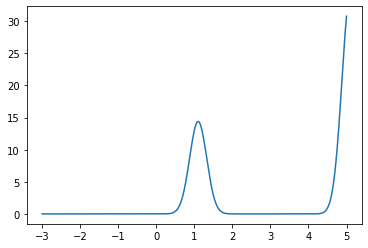

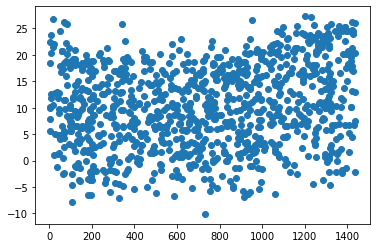

In [39]:
### PCW ### 


import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics.pairwise import rbf_kernel #get radial basis function kernel 
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np

years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]


usecols = [1, 2, 8] #[WBANNO (station number), UTC Date, Latitude]

data = [np.loadtxt(f, usecols=usecols) for f in files] #load data with relevant columns
#vstack() function is used to stack the sequence of input arrays vertically to make a single array. 
data = np.vstack(data) 

print(data)

# Map data from HHmm to an integer
data[:, 1] = np.floor_divide(data[:, 1], 100) * 60 + np.mod(data[:, 1], 100)
valid = data[:, 2] > -1000 

x_train = data[valid, 1].reshape(-1, 1) #utc time in minutes 
y_train = data[valid, 2] #latitude

import random 
sigma = 0.1
alp = 0.0001

number_of_rows = x_train.shape[0]
random_indices = np.random.choice(number_of_rows, size=1000, replace=True)
w = np.random.sample(size =1000)

x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
x_train = x_train[random_indices, :]
y_train = y_train[random_indices, :]

print(max(x_train), max(y_train))
print(min(x_train), min(y_train))
print(len(x_train),len(y_train))

rbf = rbf_kernel(y_train, x_train, gamma=1.0/sigma)
regression = Ridge(alpha=alp, fit_intercept=False)
regression.fit(rbf, y_train)

print("Score on training data = ", regression.score(rbf, y_train))
all_rbf = np.linspace(-3.0, 5.0, 1000).reshape(-1, 1)

# New representation:
expanded_rbf = rbf_kernel(all_rbf, y_train, gamma=1 / sig)
all_y = regression.predict(expanded_rbf)

print("all_x.shape", all_rbf.shape)
print("expanded_x.shape", expanded_rbf.shape)
print("all_y.shape", all_y.shape)

# Show that the predictions tend to zero far away from inputs
plt.figure()
plt.plot(all_rbf, all_y)
#plt.scatter(x_train, weights)

# Zoom in and see how well predictions fit the data
zoom_ind = (all_rbf > x_train.min()) & (all_rbf < x_train.max())
plt.figure()
print(len(zoom_ind))

#plt.plot(all_rbf[zoom_ind], all_y[zoom_ind])
plt.scatter(x_train, y_train)
plt.show()

In [41]:
all_rbf.shape


(1000, 1)

In [45]:
print(y_train.min(), y_train.max())
print(all_rbf.min(),all_rbf.max())


-10.1 27.3
-3.0 5.0
